# Lab 5-1: Surface Energy Balance at Kettle Ponds
Written by Daniel Hogan - April, 2023

In [49]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
from pysolar.solar import *

### SOS Data

In [26]:
def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

### Use this if you need to download data still...

In [27]:
local_download_dir = '../data/sosnoqc/'
download_sos_data_day('20230101', local_download_dir)

Caching...skipping download for 20230101


'../data/sosnoqc/isfs_20230101.nc'

### Import a subset of days

In [32]:
datelist = ['20230101','20230102','20230103','20230104']

sos_datasets = [xr.open_dataset(f'../data/sosnoqc/isfs_{date}.nc') for date in datelist]
sos_ds = xr.concat(sos_datasets, dim='time')

In [35]:
SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
sos_ds = sos_ds.assign(LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),
              LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA))

In [39]:
VARIABLES = ['Rsw_in_9m_d',
            'Rsw_out_9m_d',
            'LWout',
            'LWin']

sos_seb_ds = sos_ds[VARIABLES]

### Pull in the data from SPLASH RADSYS

In [6]:
'''
radsys_grabber.py

Given a start and end date, this will load radys data into an xarray dataset
'''
import pandas as pd
import xarray as xr
import datetime as dt
import json
import pytz

def get_daily_radsys_data(start, end):
    # url to request from
    base_url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/'

    # format dates
    if not isinstance(start, dt.date): 
        start = dt.datetime.strptime(start,'%Y-%m-%d')
    if not isinstance(end, dt.date): 
        end = dt.datetime.strptime(end ,'%Y-%m-%d')

    # get time delta    
    delta = end - start
    
    dates = []
    for i in range(delta.days + 1):
        dates.append(start + dt.timedelta(days=i))

    url_list = []
    for date in dates:
        if date.timetuple().tm_yday < 10:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}00{date.timetuple().tm_yday}.dat')
        elif date.timetuple().tm_yday < 100:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}0{date.timetuple().tm_yday}.dat')
        else: 
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}{date.timetuple().tm_yday}.dat')
    datasets = []
    for fn in url_list:
        # read in data
        print(f'Grabbing {fn}...')
        ckp_df = pd.read_csv(fn, 
                             skiprows=2, 
                             header=None, 
                             delim_whitespace=True, 
                             parse_dates={'time':[0,2,3,4,5]}, 
                             infer_datetime_format=True)
        datasets.append(met_data_formatting(ckp_df))
        print('Done!')
    radsys_ds = xr.concat(datasets, dim='time')
    radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                       'no_data': -9999.9,
                       'time':'UTC',
                       'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                       'datastreamname':'Radsys'})
    # add a coordinate with LocalTime for Plotting
    # time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
    # us_mtn = pytz.timezone('US/Mountain')
    # tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    # local_da=xr.DataArray.from_series(tz_corrected)
    # radsys_ds.coords.update({'local_time':tz_corrected})


    with open('radsys_attributes.txt', 'r') as j:
        attribute_dict = json.loads(j.read())
    for variable in radsys_ds.variables:
        if variable in attribute_dict.keys():
            radsys_ds[variable].attrs.update(attribute_dict[variable])
    return radsys_ds

def met_data_formatting(ckp_df):
    
    # Convert DateTime column to datetime
    ckp_df['time'] = pd.to_datetime(ckp_df['time'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [f'{col_name}_qc' for col_name in ckp_df.columns[4::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names)))

    ckp_ds = ckp_df.set_index('time', drop=True).to_xarray()
    return ckp_ds

### Define start and end dates -- Note this is not in local time!

In [8]:
radsys_ds = get_daily_radsys_data('2023-01-01','2023-01-04')

Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23001.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23002.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23003.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23004.dat...
Done!


In [11]:
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'LocalTime':tz_corrected})

In [12]:
netrad = (radsys_ds.where(radsys_ds['dw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['dw_solar'] - \
radsys_ds.where(radsys_ds['uw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['uw_solar']) + \
(radsys_ds.where(radsys_ds['dw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['dw_ir'] - \
radsys_ds.where(radsys_ds['uw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['uw_ir'])

In [13]:
total_dw_solar = np.round(radsys_ds.where(radsys_ds['dw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['dw_solar'].sum().values,-1)
total_uw_solar = np.round(radsys_ds.where(radsys_ds['uw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['uw_solar'].sum().values,-1)
total_dw_lw = np.round(radsys_ds.where(radsys_ds['dw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['dw_ir'].sum().values,-1)
total_uw_lw = np.round(radsys_ds.where(radsys_ds['uw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['uw_ir'].sum().values,-1)
total_netrad = np.round(netrad.sum().values,-1)

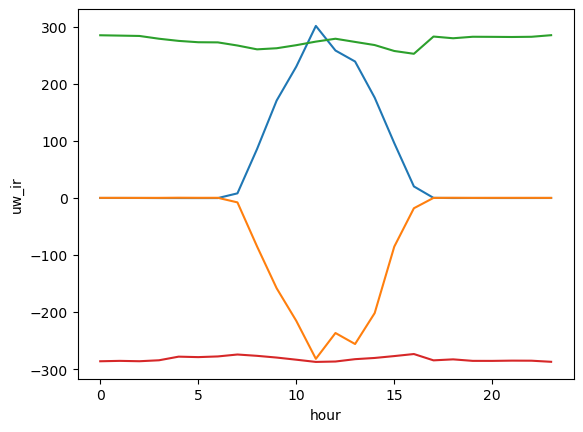

In [23]:
import matplotlib.pyplot as plt
# Plot of diurnal energy balance for the period we downloaded from the SPLASH data
radsys_ds.where(radsys_ds['dw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['dw_solar'].plot()
(-radsys_ds.where(radsys_ds['uw_solar_qc'] == 0).groupby('LocalTime.hour').mean()['uw_solar']).plot()
radsys_ds.where(radsys_ds['dw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['dw_ir'].plot()
(-radsys_ds.where(radsys_ds['uw_ir_qc'] == 0).groupby('LocalTime.hour').mean()['uw_ir']).plot()

### Use Pysolar to get clear sky radiation time series

In [75]:
import pytz
kettle_ponds_lat_lon = [-106.97298,38.94182]
dates = pd.date_range(dt.datetime(2022,1,20,0,0),dt.datetime(2022,1,25,0,0),  freq='1H')

clear_sky_rad = []
for date in dates:
    date = (pytz.utc.localize(date)).to_pydatetime()
    altitude_deg = get_altitude(kettle_ponds_lat_lon[1], kettle_ponds_lat_lon[0], date)
    clear_sky_rad.append(radiation.get_radiation_direct(date, altitude_deg))

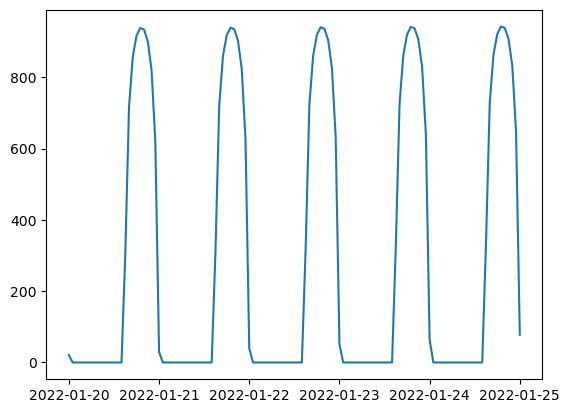

In [76]:
plt.plot(dates,clear_sky_rad)